In [47]:
import time
import requests
import numpy as np
import pandas as pd
from talib import abstract
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime
import mplfinance as mpf
import pandas_datareader as web

In [48]:
# # DataFrame Setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
pd.set_option('display.width', 5000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# # Global Variables Setting
symbol = 'BTCUSDT'
url = 'https://api.binance.com/'

# # Get Market Data
def GetKline(url, symbol, interval, startTime = None, endTime = None):
    try:
        data = requests.get(url + 'api/v3/klines', params={'symbol': symbol, 'interval': interval, 'startTime': startTime, 'limit': 1000}).json()
    except Exception as e:
        print ('Error! problem is {}'.format(e.args[0]))
    tmp  = []
    pair = []
    for base in data:
        tmp  = []
        for i in range(0,6):
            if i == 0:
                base[i] = datetime.fromtimestamp(base[i]/1000)
            tmp.append(base[i])
        pair.append(tmp)
    df = pd.DataFrame(pair, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    df = df.astype(float)
    return df

def GetHistoricalKline(url, symbol, interval, startTime):
    # init
    klines = GetKline(url, symbol, interval)
    tmptime = ToMs(klines.iloc[0].name)
    
    # Send request until tmptime > startTime
    while tmptime > startTime:
        tmptime -= PeriodToMs(interval) * 1000 # tmp minus period ms plus 1000 (1000 K)
        if tmptime < startTime:
            tmptime = startTime
        tmpdata = GetKline(url, symbol, interval, tmptime)
        klines  = pd.concat([tmpdata, klines])

    return klines.drop_duplicates(keep='first', inplace=False)

# Math Tools
def ToMs(date):
    return int(time.mktime(time.strptime(str(date), "%Y-%m-%d %H:%M:%S")) * 1000) # Binance timestamp format is 13 digits

def PeriodToMs(period):
    Ms = None
    ToSeconds = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }
    unit = period[-1]

    if unit in ToSeconds:
        try:
            Ms = int(period[:-1]) * ToSeconds[unit] * 1000
        except ValueError:
            pass
    return Ms

In [49]:
if __name__ == "__main__":
    klines = GetKline(url, symbol, '1d', ToMs('2021-01-01 08:00:00'))
    print (klines)

                         open      high       low     close         volume
date                                                                      
2021-01-01 08:00:00  28923.63  29600.00  28624.57  29331.69   54182.925011
2021-01-02 08:00:00  29331.70  33300.00  28946.53  32178.33  129993.873362
2021-01-03 08:00:00  32176.45  34778.11  31962.99  33000.05  120957.566750
2021-01-04 08:00:00  33000.05  33600.00  28130.00  31988.71  140899.885690
2021-01-05 08:00:00  31989.75  34360.00  29900.00  33949.53  116049.997038
2021-01-06 08:00:00  33949.53  36939.21  33288.00  36769.36  127139.201310
2021-01-07 08:00:00  36769.36  40365.00  36300.00  39432.28  132825.700437
2021-01-08 08:00:00  39432.48  41950.00  36500.00  40582.81  139789.957499
2021-01-09 08:00:00  40586.96  41380.00  38720.00  40088.22   75785.979675
2021-01-10 08:00:00  40088.22  41350.00  35111.11  38150.02  118209.544503
2021-01-11 08:00:00  38150.02  38264.74  30420.00  35404.47  249131.539943
2021-01-12 08:00:00  3541

In [50]:
def RSI(df, period):
    return abstract.RSI(df, timeperiod=period)

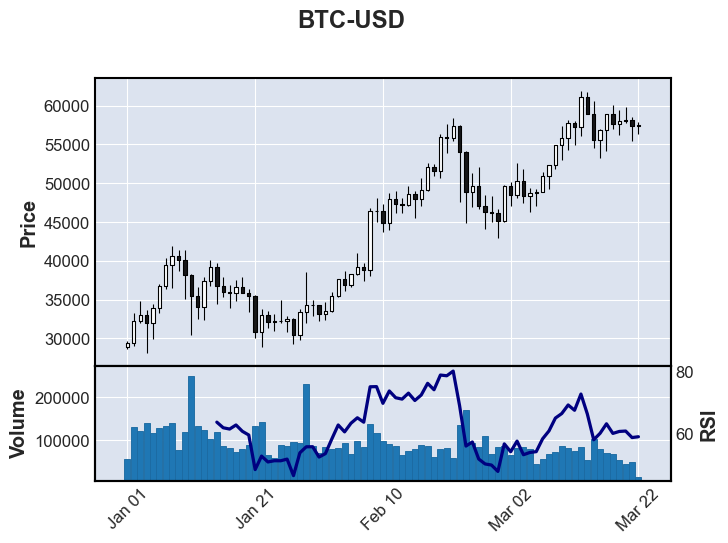

In [51]:
df = web.DataReader('BTC-USD','yahoo','2021-01-01')
index  = mpf.make_addplot(RSI(klines, 14), panel = 1, ylabel = 'RSI', color = 'navy')
mpf.plot(klines, type = 'candle', title = 'BTC-USD',addplot = [index],volume = True)